# Menu <a class="anchor" id="menu"></a>

* [1. Segmentation par **RFM** ](#rfm)
* ~~[2. Segmentation par **KMeans** ](#kmeans)~~
* ~~[3. Segmentation par **CAH** ](#cah)~~
* ~~[4. Segmentation par **DBScan** ](#dbscan)~~

# La segmentation

Segmenter consiste à **créer des segments homogènes de clients** que l’on peut ensuite activer dans des campagnes marketing ciblées. Cette approche permet de mieux cibler les campagnes et scénarios marketing; on segmente les clients en fonction de critères de segmentation.

Il y a théoriquement autant de méthodes de segmentation qu’il y a de critères et de combinaisons de critères possibles. Mais certaines méthodes se sont imposées en raison de leur efficacité.

---
# Préparatifs 

In [1]:
import os
#import re
#import math
#import string
import datetime
#import unicodedata
#import json
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import squarify

random_seed = 0
np.random.seed(random_seed)

#import warnings
#warnings.filterwarnings('ignore')

#import gc
#gc.enable()

In [2]:
def load_from_zip( csv_name ):
    return pd.read_csv(ZipFile(os.path.join("data",f"{csv_name}.zip")).open(csv_name))

#data_geo = load_from_zip("olist_geolocation_dataset.csv")
#data_geo = pd.read_csv(os.path.join('data',"olist_geolocation_dataset_clean.csv"))

#data_customer = load_from_zip("olist_customers_dataset_clean.csv")
data_customer = pd.read_csv(os.path.join('data',"olist_customers_dataset_clean.csv"))

#data_orders = load_from_zip("olist_orders_dataset.csv")
data_orders = pd.read_csv(os.path.join('data',"olist_orders_dataset_clean.csv"))

#data_items = load_from_zip("olist_order_items_dataset.csv")
#data_items = pd.read_csv(os.path.join('data',"olist_order_items_dataset_clean.csv"))

#data_products = load_from_zip("olist_products_dataset.csv")
#data_products = pd.read_csv(os.path.join('data',"olist_products_dataset_clean.csv"))

#data_payments = load_from_zip("olist_order_payments_dataset.csv")
data_payments = pd.read_csv(os.path.join('data',"olist_order_payments_dataset_clean.csv"))

#data_reviews = load_from_zip("olist_order_reviews_dataset.csv")
#data_reviews = pd.read_csv(os.path.join('data',"olist_order_reviews_dataset_clean.csv"))

#data_sellers = pd.read_csv(os.path.join('data',"olist_sellers_dataset_clean.csv"))
#data_categories = pd.read_csv(os.path.join('data',"product_category_name_translation_clean.csv"))

---
# 1. Segmentation RFM *(Récence, Fréquence et Montant)* <a class="anchor" id="rfm"></a> [⇪](#menu)

La segmentation RFM est l’une des techniques de segmentation incontournables pour améliorer le ciblage marketing et augmenter le revenu par client. 

Cette méthode est une **segmentation 100% comportementale**; on ne segmente pas  les clients en fonction de ce qu’ils sont *(genre, sexe, ville, CSP...)*, ni en fonction de ce qu’ils aiment *(centres d’intérêt, goûts)*, mais en fonction de ce qu’ils achètent.

Le principe sous-jacent est simple : un client qui a acheté récemment, qui achète fréquemment et qui génère beaucoup de chiffre d’affaires commandera à nouveau, à coup quasiment sûr.

La segmentation RFM repose sur ces 3 critères :
- La **Récence** : Combien de temps s’est-il écoulé depuis la dernière activité du client *(achat/visite web/visite app...)* ?
- La **Fréquence** : Au cours d’une période de temps donnée, combien de fois un client a-t-il acheté ou interagi avec la marque ? 
- Le **Montant** : Combien un client a-t-il dépensé d’argent au cours d’une période de temps donnée ?

## Préparatifs

> **Temporalité** : comme nos analyses ont montrés que l'activité n'était pas fiable au début et à la fin de la timeline disponible, nous pourrions restreintre notre jeu de données entre **Janvier 2017** et **Aout 2018**. Mais comme il est recommandé de faire une RFM sur une période cyclique et réutilisable d'une semaine, d'un mois ou d'une année, nous allons prendre les données allant de fin août 2017 à fin août 2018 (donc les données les plus récentes sur 1 an).

#### D'abord on restreint la selection entre le 01/09/2017 et le 01/09/2018 pour avoir une période d'un an et on ne garde que ceux dont le processus de livraison est allé jusqu'au bout (delivered)

In [3]:
selection1 = data_orders[ 
    (data_orders.order_purchase_timestamp >= '2017-09-01 00:00:00') & 
    (data_orders.order_purchase_timestamp < '2018-09-01 00:00:00') & 
    (data_orders.order_status == 'delivered') ][['order_id', 'customer_id', 'order_purchase_timestamp']]
selection1.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


#### Puis on associe ces commandes aux id uniques des clients qui les ont passées

In [4]:
selection2 = selection1.merge(data_customer[['customer_id','customer_unique_id']], on='customer_id', how='left')
selection2.head()

,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


## Calcul de la `Récence`

#### On converti la date d'achat en nombre de jours écoulés *(depuis le moment ou l'on arrête notre selection donc le 01/09/2018)*

In [5]:
ref_date = datetime.datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
selection3 = selection2.copy()

selection3.order_purchase_timestamp = selection2.order_purchase_timestamp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
selection3['days_ago'] = selection3.order_purchase_timestamp - ref_date
selection3['days_ago'] = selection3.days_ago.apply(lambda x: x.days)
selection3.drop(columns=['order_purchase_timestamp'], inplace=True)
selection3.head()

,order_id,customer_id,customer_unique_id,days_ago
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,-334
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,-39
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,-24
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,-287
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,-200


In [6]:
selection3.describe().T

,count,mean,std,min,25%,50%,75%,max
days_ago,74213.0,-176.203778,99.367873,-365.0,-263.0,-176.0,-92.0,-3.0


#### Puis, on crée une **nouvelle table** `R_data` qui stoque la **recence** *(la plus petite valeur `days_ago`)* de chaque client

In [7]:
R_data = selection3[['customer_unique_id', 'days_ago']].groupby('customer_unique_id').min().reset_index()
R_data.rename(columns={'days_ago':'recence'}, inplace=True)
R_data.head()

,customer_unique_id,recence
0,0000366f3b9a7992bf8c76cfdf3221e2,-114
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-117
2,0000f6ccb0745a6a4b88665a16c9f078,-324
3,0004aac84e0df4da2b147fca70cf8255,-291
4,0004bd2a26a76fe21f786e4fbd80607f,-149


In [8]:
R_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.54805,99.464265,-365.0,-264.0,-176.0,-92.5,-3.0


## Calcul de la `Fréquence`

#### On ajoute la fréquence de chaque commande; c'est à dire 1...

In [9]:
selection4 = selection3.copy()
selection4['frequence'] = 1

#### Puis, on crée une **nouvelle table** `F_data` qui stoque la **frequence** *(le total du nombre de commande passées dans la période choisie)* de chaque client

In [10]:
F_data = selection4[['customer_unique_id', 'frequence']].groupby('customer_unique_id').sum().reset_index()
F_data.sort_values('frequence', ascending=False).head()

,customer_unique_id,frequence
39752,8d50f5eadf50201ccdcedfb9e2ac8455,11
17595,3e43e6105506432c953e165fb2acf44c,9
28323,6469f99c1f9dfae7733b25662e7f1782,7
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,7
57218,ca77025e7201e3b30c44b472ff346268,7


In [11]:
F_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequence,72247.0,1.027212,0.185742,1.0,1.0,1.0,1.0,11.0


## Calcul du `Montant`

#### On calcul le montant total de chaque commande *(puisqu'il peut y avoir plusieurs moyens de paiements)*

In [12]:
total_amount_per_order = selection3[['order_id']].merge( data_payments[['order_id','payment_value']], on='order_id', how='left').groupby('order_id').sum().reset_index()
total_amount_per_order.rename(columns={'payment_value':'montant'}, inplace=True)
total_amount_per_order.head()

,order_id,montant
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,000229ec398224ef6ca0657da4fc703e,216.87
2,00024acbcdf0a6daa1e931b038114c75,25.78
3,00054e8431b9d7675808bcb819fb4a32,31.75
4,000576fe39319847cbb9d288c5617fa6,880.75


#### Puis, on crée une **nouvelle table** `M_data` qui stoque le **montant** *(le total des montants de toutes les commandes faites sur la période choisie)* pour chaque client

In [13]:
M_data = selection3[['customer_unique_id', 'order_id']].merge(total_amount_per_order, on='order_id', how='left').groupby('customer_unique_id').sum().reset_index()
M_data.head()

,customer_unique_id,montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


In [14]:
M_data.describe().T

,count,mean,std,min,25%,50%,75%,max
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


## Calcul des `scores RFM`

#### On associe les trois jeux de données `R_data`, `F_data` et `M_data` en un unique jeu de données `RFM_data`

In [15]:
from functools import reduce
RFM_data = reduce(lambda x,y: pd.merge(x,y, on='customer_unique_id', how='left'), [R_data, F_data, M_data])
RFM_data.sort_values(['frequence','recence','montant'], ascending=False)

,customer_unique_id,recence,frequence,montant
39752,8d50f5eadf50201ccdcedfb9e2ac8455,-361,11,557.15
17595,3e43e6105506432c953e165fb2acf44c,-348,9,1172.66
7709,1b6c7548a2a1f9037c1fd3ddfed95f33,-292,7,959.01
57218,ca77025e7201e3b30c44b472ff346268,-327,7,1122.72
28323,6469f99c1f9dfae7733b25662e7f1782,-347,7,758.83
...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10


In [16]:
RFM_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recence,72247.0,-176.548050,99.464265,-365.0,-264.00,-176.0,-92.50,-3.00
frequence,72247.0,1.027212,0.185742,1.0,1.00,1.0,1.00,11.00
montant,72247.0,164.548839,217.050575,0.0,63.13,108.2,182.14,7274.88


#### Puis, on utilise les quantiles pour calculer les seuil de répartition des scores pour chacune des 3 colonnes...

In [17]:
num_groups = 3 # En combien de groupes voulont nous découper nos scores

R_groups = RFM_data.recence.quantile(np.linspace(0,1,num_groups+1))
R_groups.pop(0)

F_groups = RFM_data.frequence.quantile(np.linspace(0,1,num_groups+1))
F_groups.pop(0)

M_groups = RFM_data.montant.quantile(np.linspace(0,1,num_groups+1))
M_groups.pop(0)

0.0

In [18]:
r_start, f_start, m_start = 0,0,0
for i,(r,f,m) in enumerate(zip(R_groups, F_groups, M_groups)):
    print(f"score:{i} | Recence:[{r_start:6};{r:6}] | Frequence:[{f_start:6};{f:6}] | Montant:[{m_start:6};{m:6}]")
    r_start, f_start, m_start = r, f, m

score:0 | Recence:[     0;-229.0] | Frequence:[     0;   1.0] | Montant:[     0; 75.25]
score:1 | Recence:[-229.0;-122.0] | Frequence:[   1.0;   1.0] | Montant:[ 75.25;152.71]
score:2 | Recence:[-122.0;  -3.0] | Frequence:[   1.0;  11.0] | Montant:[152.71;7274.88]


>#### 🔔 On note que les **scores de fréquence vont présenter un problème** puisque le score 2 est inexistant de par la répartition des achats
> *(rappelons que notre Analyse Exploratoire des données a montrée que seuls environ 3% des clients font plus d'un achat)*

#### On utilise les seuils pour calculer et ajouter les scores `R_score`, `F_score` et `M_score` des 3 colonnes `recence`, `frequence` et `montant`

In [19]:
def eval_score(x, split_values):
    for i,v in enumerate(split_values):
        if(x <= v):
            return i+1
        
    print(f"probleme: value={x}\n", split_values)
    raise Exception

RFM_data['R_score'] = RFM_data.recence.apply(eval_score, split_values=R_groups)
RFM_data['F_score'] = RFM_data.frequence.apply(eval_score, split_values=F_groups)
RFM_data['M_score'] = RFM_data.montant.apply(eval_score, split_values=M_groups)
RFM_data['RFM_score'] = RFM_data[['R_score','F_score','M_score']].apply(lambda row: int(''.join(row.values.astype(str))), axis=1)

In [20]:
RFM_data.sort_values(['recence','frequence','montant'], ascending=False)

,customer_unique_id,recence,frequence,montant,R_score,F_score,M_score,RFM_score
26076,5c58de6fb80e93396e2f35642666b693,-3,1,510.96,3,1,3,313
49731,afbcfd0b9c5233e7ccc73428526fbb52,-3,1,497.25,3,1,3,313
3475,0c6d7218d5f3fa14514fd29865269993,-3,1,178.25,3,1,3,313
1154,0421e7a23f21e5d54efed456aedbc513,-3,1,119.42,3,1,2,312
51155,b4dcade04bc548b7e3b0243c801f8c26,-3,1,106.95,3,1,2,312
...,...,...,...,...,...,...,...,...
45706,a1efe9a98bf03a0025efa9bc56fe9d1f,-365,1,35.00,1,1,1,111
53024,bb7ff07987c9bb0345b6b948478525b4,-365,1,31.75,1,1,1,111
35090,7c3db55121184d445bec70d421c62135,-365,1,31.38,1,1,1,111
69236,f514fa8c60b510de4c90242e86801717,-365,1,31.10,1,1,1,111


#### Ce qui nous permet d'avoir la ségmentation par groupes des clients

In [21]:
RFM_groups_size = RFM_data.groupby('RFM_score').size()
RFM_groups_size

RFM_score
111    8011
112    7962
113    7491
131      20
132     204
133     606
211    8114
212    7525
213    7561
231      34
232     140
233     502
311    7914
312    8158
313    7717
331      11
332      73
333     204
dtype: int64

>#### On pourrait les intérpêter comme suit:
>
> **Champions** | RFM_score = **333**
>> A acheté récemment, achète souvent et dépense le plus.<br>
>> Récompensez-les. Ils peuvent devenir des early adopters de vos nouveaux produits. Ils vont promouvoir votre marque.
>
> **Clients fidèles** | RFM_score = **233** ou **332**
>> Dépense pas mal d’argent et assez souvent. Sensible aux promotions.<br>
>> Proposez-leur des produits de gamme supérieure (up-sell). Demandez-leur des feedbacks. Engagez-les.
>
> **Clients récents**  | RFM_score = **313**, **312** ou **311**
>> A acheté récemment mais n’achète pas souvent.<br>
>> Envoyez-leur un programme d’onboarding. Construisez une relation clients.
>
> **Clients à risque** | RFM_score = **133**
>> A dépensé beaucoup d’argent et acheté souvent... mais il y a très longtemps. Vous devez les faire revenir à vous !<br>
>> Envoyez-leur des emails personnalisés pour reconnecter avec eux. Offrez-leur des promotions sur leur renouvellement. Fournissez-leur des ressources utiles.
>
> **Clients que vous ne devez pas perdre** | RFM_score = **123** ou **132**
>> A fait les plus gros achats et acheté souvent. Mais cela fait un moment qu’il n’a plus racheté.<br>
>> Reconquérez-les avec des promotions ou des nouveaux produits. Ne les laissez pas partir chez la concurrence, parlez-leur.
>
> **Clients en hibernation** | RFM_score = **112** ou **113**
>> Son dernier achat remonte à il y a moment... Ne dépense pas beaucoup et pas souvent du tout.<br>
>> Offrez-leur des promotions spéciales, présentez-leur des produits pertinents. Recréez de la brand value.
>
> **Clients perdus** | RFM_score = **111**
>> A les plus faibles scores en Récence, Fréquence et Montant.<br>
>> Essayez de réveiller leur intérêt avec une campagne, sinon laissez tomber.

#### Enfin, on peut afficher ces groupes sous forme de `treemap`

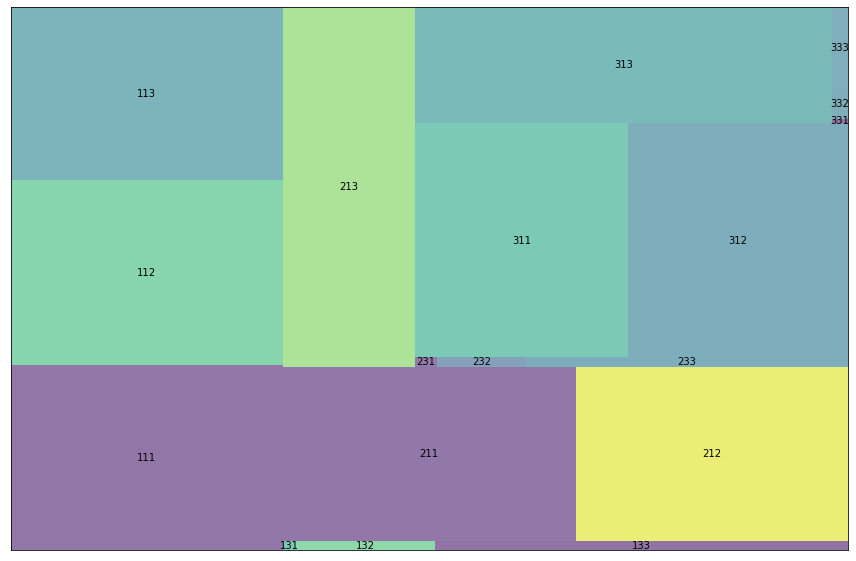

In [22]:
fig = plt.figure(figsize=(15,10))
ax = squarify.plot(sizes=RFM_groups_size, label=RFM_groups_size.keys(), alpha=0.6 )
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()